In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import json

# Load and prepare the dataset
file_path = 'goal_ticks.csv'

# Define column names based on the provided structure, including kart_ID, ball_node, kart_sector, and ball_approaching_goal
column_names = [
    "kart_ID", "ball_X", "ball_Z", "ball_aim_X", "ball_aim_Z", "ball_node", "previous_X", "previous_Z", "ball_heading",
    "dist_to_ball", "kart_X", "kart_Z", "vel_X", "vel_Z", "speed", "steer", "accel", "brake", "skid", "time", "kart_sector",
    "ball_approaching_goal", "goal"
]

df = pd.read_csv(file_path, header=None, names=column_names)

# Extract features and labels
X = df.iloc[:, :-1].values  # All columns except the last one (goal)
y = df['goal'].values  # The 'goal' column as binary

# Normalize all features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Save the scaler parameters for later use
scaler_params = {
    "mean": scaler.mean_.tolist(),
    "scale": scaler.scale_.tolist()
}

print("Scaler parameters:")
print(json.dumps(scaler_params, indent=4))

with open('scaler_parameters.json', 'w') as f:
    json.dump(scaler_params, f)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # Keeping the target as a 2D tensor for BCELoss

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Prepare data loaders
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Define the neural network architecture
class ScoringModel(nn.Module):
    def __init__(self, num_inputs=22):  # Set to 22 inputs
        super(ScoringModel, self).__init__()
        self.layer1 = nn.Linear(num_inputs, 512)
        self.layer2 = nn.Linear(512, 256)
        self.layer3 = nn.Linear(256, 128)
        self.layer4 = nn.Linear(128, 64)
        self.layer5 = nn.Linear(64, 32)
        self.output_layer = nn.Linear(32, 1)  # Binary classification
        self.leaky_relu = nn.LeakyReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.leaky_relu(self.layer1(x))
        x = self.dropout(x)
        x = self.leaky_relu(self.layer2(x))
        x = self.dropout(x)
        x = self.leaky_relu(self.layer3(x))
        x = self.dropout(x)
        x = self.leaky_relu(self.layer4(x))
        x = self.dropout(x)
        x = self.leaky_relu(self.layer5(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.output_layer(x))
        return x

# Initialize the model with 22 inputs
model = ScoringModel(num_inputs=22)

# Set up the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Training function
def train_model(train_loader, model, criterion, optimizer, num_epochs=150):
    model.train()
    for epoch in range(num_epochs):
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        if (epoch + 1) % 10 == 0:  # Print every 10 epochs
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')

# Validation function
def validate_model(val_loader, model, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
    print(f'Validation Loss: {total_loss / len(val_loader):.4f}')

# Train and validate the model
train_model(train_loader, model, criterion, optimizer, 150)
validate_model(val_loader, model, criterion)

# Save the trained model for deployment
model.eval()

example_input = torch.rand(1, X_train.shape[1])  # Generate a random example input
traced_script_module = torch.jit.trace(model, example_input)
traced_script_module.save("soccer_ai_model.pt")

# Print the weights of the output layer after training
print("Weights of the output layer after training:")
print(model.output_layer.weight)
print("Bias of the output layer after training:")
print(model.output_layer.bias)

# Example output
example_output = model(example_input)
print("Example output:", example_output.item())


Scaler parameters:
{
    "mean": [
        0.5,
        0.36820240706346236,
        -6.732118916570887,
        0.3831782690527264,
        -5.356374004445242,
        249.29791680271666,
        0.3657498038961568,
        -12.978128716678965,
        -0.005108301860887221,
        17.4162196636518,
        0.37305256631725325,
        -12.704423337382453,
        0.021111525153746702,
        1.741761120301848,
        5.2016913733429115,
        0.016386959461389017,
        0.5482958299484098,
        0.21396852347678444,
        0.0,
        4276153.5531901,
        285.66727617057404,
        0.07300986090250114
    ],
    "scale": [
        0.5,
        24.192647229059684,
        34.65133311294775,
        24.899218134808155,
        34.92212936978427,
        142.75731165029117,
        23.39163859817141,
        34.10762840974104,
        1.7651976529064284,
        17.33753842874742,
        23.394478607280533,
        34.255019083907435,
        5.127938464856532,
        

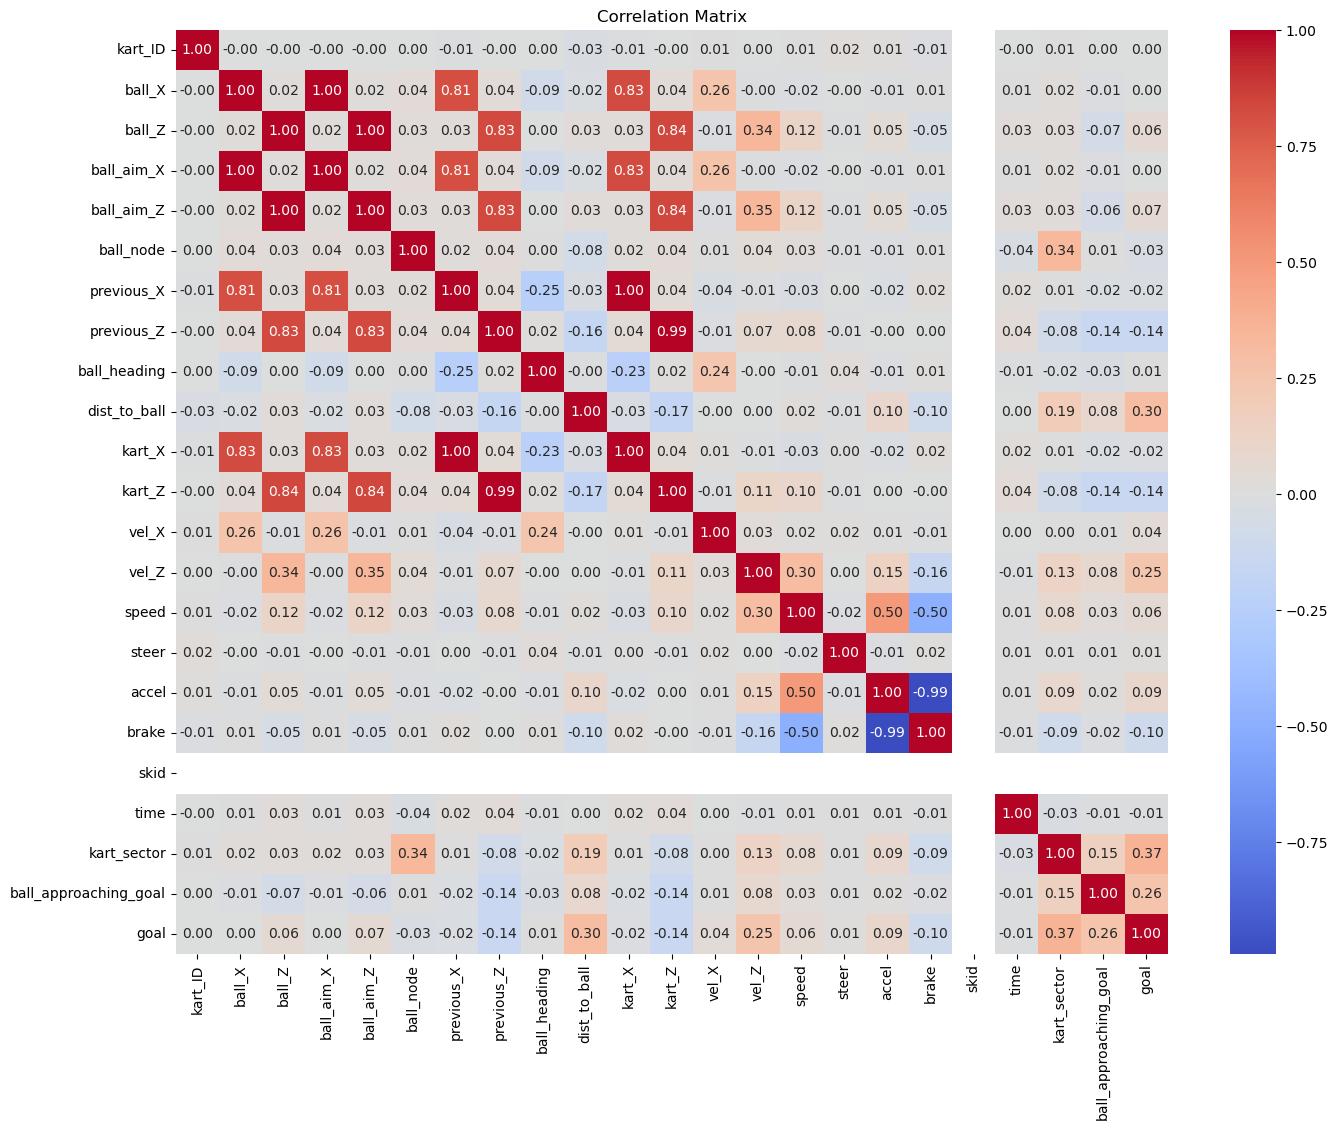

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

correlation_matrix = df.corr()
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()